# Week 9 Day 1: Confidence intervals

## Objectives:
* Look at sampling confidence intervals
* Look at frequentist confidence intervals

## Confidence intervals example

Based loosely on [A very friendly introduction to confidence intervals](https://towardsdatascience.com/a-very-friendly-introduction-to-confidence-intervals-9add126e714)

In [1]:
import numpy as np
import scipy.stats
import scipy.stats as stats
import matplotlib.pyplot as plt

Let's look at taking a small sample of a larger distribution. We'll use the same example given in the reference; this was a poll of the people in the US to see what fraction likes Soccer. Let's assume for the moment we know the real mean, and have the original distribution handy:

In [2]:
love_soccer_prop = 0.65  # Real percentage of people who love soccer
total_population = 325 * 10 ** 6  # Total population in the U.S. (325M)
# Note: 325e6 would be a floating point number

love_soccer_num = int(love_soccer_prop * total_population)

Bools are smaller than ints, and we can still take the mean, sum, etc. of an array of bools, so we'll use bools. We'll start off with a "sorted" array (people who love Soccer first), we we'll need to be careful when we select samples from it.

In [3]:
population = np.zeros(total_population, dtype=bool)
population[:love_soccer_num] = True

In [4]:
np.mean(population)

0.65

In [5]:
for i in range(10):
    sample = np.random.choice(population, size=1000)
    print(f"Sample {i}: {np.mean(sample)}")

Sample 0: 0.623
Sample 1: 0.663
Sample 2: 0.645
Sample 3: 0.639
Sample 4: 0.642
Sample 5: 0.658
Sample 6: 0.643
Sample 7: 0.629
Sample 8: 0.655
Sample 9: 0.646


In [6]:
values = np.empty(10_000)
for i in range(len(values)):
    values[i] = np.mean(np.random.choice(population, size=1_000))

In [7]:
np.mean(values)

0.6497625

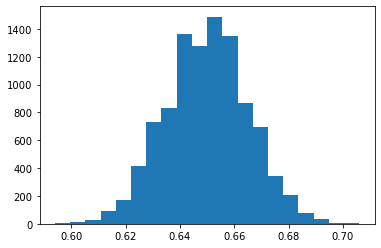

In [8]:
plt.hist(values, bins=20)
plt.show()

In [9]:
confidence = 0.95
sem = np.std(sample) / np.sqrt(len(sample))  # scipy.stats.sem(sample)
h = sem * scipy.stats.t.ppf((1 + confidence) / 2, len(sample) - 1)
print(f"{np.mean(sample)} +/- {h:.3g} ({confidence:.1%})")

0.646 +/- 0.0297 (95.0%)


For larger samples (more than 100), we can approximate the student's t distribution with a Gaussian:

In [10]:
sem = scipy.stats.sem(sample)
h = sem * scipy.stats.norm.ppf((1 + confidence) / 2)
print(f"{np.mean(sample)} +/- {h:.3g} ({confidence:.1%})")

0.646 +/- 0.0297 (95.0%)


In SciPy, we can do this even quicker:

In [11]:
h = scipy.stats.t.interval(confidence, len(sample) - 1, loc=np.mean(sample), scale=sem)
print(h)

(0.6163100322541999, 0.6756899677458001)


Anaconda includes another popular package for statistics: StatsModels, which complements `scipy.stats` and `pandas`.

In [12]:
import statsmodels.stats.api as sms

In [13]:
inter = sms.DescrStatsW(sample).tconfint_mean()
inter

(0.6163100322541999, 0.6756899677458001)

## Physics confidence intervals

Based on the excellent slides here: <http://www.phas.ubc.ca/~oser/p509/Lec_16.pdf>

For simplicity, we will assume that we are using 90% confidence intervals in the notes below.

In Physics, frequentist confidence intervals are often used for measurements. We make a measurement, then construct a confidence interval from the expected underlying probability distribution for the different possible measurements; we quote the true values for which our measurement is in the 90% range.

This does not tell us that there is a 90% chance the true value is in this range, rather that if we did this experiment many times, 90% of the experiments would contain the true value.

#### Neyman confidence interval construction:

1. Calculate the PDF of obtaining a measurement $\hat{a}$ from the true value $a$: $\mathrm{P}(\hat{a}|a)$
2. Define the interval where $\hat{a}$ has a 90% chance of occurring
3. Repeat for all possible true $a$

If we have the following distribution, the Neyman confidence interval construction *does not specify* how to draw the confidence region; any region that contains 90% of the probability could be a 90% confidence interval.

$$
\mathrm{PDF}(x) = x e^{-\frac{1}{2} x^2}
$$

In [14]:
import sympy as s

s.init_printing()

In [15]:
x = s.symbols("x")
f = x * s.exp(-(x ** 2) / 2)

In [16]:
f.integrate(x)

This is normalized:

In [17]:
f.integrate((x, 0, s.oo))

This is one region:

In [18]:
f.integrate((x, 0.32, 2.45))

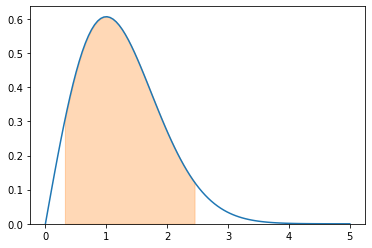

In [19]:
fn = s.lambdify([x], f)

xs = np.linspace(0, 5, 100)
plt.plot(xs, fn(xs))
xs = np.linspace(0.32, 2.45, 50)
plt.fill_between(xs, fn(xs), color="C1", alpha=0.3)
plt.ylim(ymin=0)
plt.show()

You can also choose an upper limit:

In [20]:
f.integrate((x, 0, 2.15))

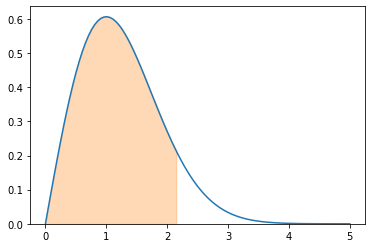

In [21]:
xs = np.linspace(0, 5, 100)
plt.plot(xs, fn(xs))
xs = np.linspace(0, 2.15, 50)
plt.fill_between(xs, fn(xs), color="C1", alpha=0.3)
plt.ylim(ymin=0)
plt.show()

How about this?

In [22]:
f.integrate((x, 0, 1.09)) + f.integrate((x, 1.26, s.oo))

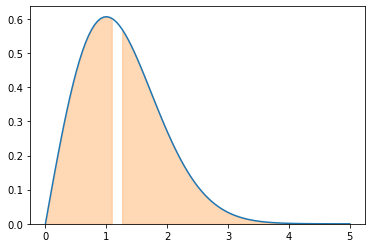

In [23]:
xs = np.linspace(0, 5, 100)
plt.plot(xs, fn(xs))
xs = np.linspace(0, 1.09, 50)
plt.fill_between(xs, fn(xs), color="C1", alpha=0.3)
xs = np.linspace(1.26, 5, 50)
plt.fill_between(xs, fn(xs), color="C1", alpha=0.3)
plt.ylim(ymin=0)
plt.show()

#### Flip flop problem

Let's take the following example. Assume I am measuring from a Gaussian distribution where I know $\mu\ge0$:

$$
\mathrm{P}(\hat{\mu} | \mu) =
 \frac{1}{\sqrt{2\pi}}
 \exp{\left[
  -\frac{1}{2} \left(
  \mu - \hat{\mu}
  \right)^2
\right]}
$$

For fixed true value $\mu$, 90% of the probability lies in $\mu-1.28<\hat{\mu}<\infty$. Or $\mu-1.65<\hat{\mu}<\mu+1.65$.

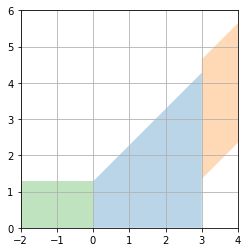

In [24]:
fig, ax = plt.subplots()

# Upper limit quote
x = np.linspace(0, 3)
ax.fill_between(x, 1.28 + x, alpha=0.3)

# Upper and lower bounds
x = np.linspace(3, 4)
ax.fill_between(x, 1.65 + x, x - 1.65, alpha=0.3)

# Quote as 0
x = np.linspace(-2, 0)
ax.fill_between(x, 1.28 + x * 0, alpha=0.3)

ax.set_xlim(-2, 4)
ax.set_ylim(0, 6)
ax.grid()
ax.set_aspect("equal")
plt.show()

#### Feldman-Cousins

A special prescription for building the limits intervals that transitions properly and avoids empty set when near a physical boundary (like 0) by using the following ordering ratio:

$$
R = \frac{P(x∣\mu)}
         {P(x∣\mu_\mathrm{best})}
$$

You simply select the 90% with the highest R.

From out previous example, $\mu_\mathrm{best}=x$ if $x>0$ or  $\mu_\mathrm{best}=0$ if $x\le 0$

#### Feldman-cousins from GammaPy (from pip)

In [25]:
import gammapy.stats as gstats

In [26]:
x_bins = np.arange(0, 50)
mu_bins = np.linspace(0, 15, int(15 / 0.005) + 1, endpoint=True)
matrix = [stats.poisson(mu + 3.0).pmf(x_bins) for mu in mu_bins]

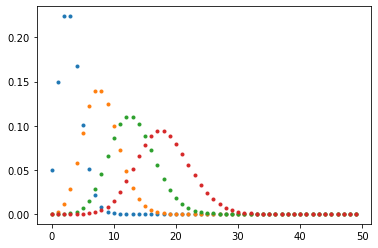

In [27]:
plt.plot(matrix[0], ".")
plt.plot(matrix[1000], ".")
plt.plot(matrix[2000], ".")
plt.plot(matrix[-1], ".")

In [28]:
acceptance_intervals = gstats.fc_construct_acceptance_intervals_pdfs(matrix, 0.9)
LowerLimitNum, UpperLimitNum, other = gstats.fc_get_limits(
    mu_bins, x_bins, acceptance_intervals
)

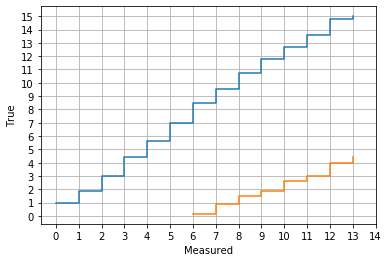

In [29]:
u = np.array([gstats.fc_find_limit(i, UpperLimitNum, mu_bins) for i in range(14)])
l = [gstats.fc_find_limit(i, LowerLimitNum, mu_bins) for i in range(14)]
plt.step(range(14), u, where="post", label="Upper limit")
plt.step(range(14), l, where="post", label="Lower limit")
plt.xticks(range(15))
plt.yticks(range(16))
plt.grid()
plt.xlabel("Measured")
plt.ylabel("True")
plt.show()